In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [10]:
!rm -rf ./data/asl_alphabet_test

In [7]:
from google.colab import drive

if not os.path.exists("./data"):
  drive.mount('/content/drive')
  !mkdir ./data
  !unzip /content/drive/MyDrive/data.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ./data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: ./data/asl_alph

In [11]:
from torch.utils.data import random_split

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

image_dataset = datasets.ImageFolder("./data/train/",
                                          data_transforms)
train_dataset, val_dataset, test_dataset, _ = random_split(image_dataset, [0.08, 0.02, 0.03, 0.87])
image_datasets = {"train": train_dataset, "val": val_dataset}

dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4) for x in ["train", "val"]}
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
test_size = len(test_dataset)
class_names = image_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
print(dataset_sizes)
print(test_size)

{'train': 6960, 'val': 1740}
2610


In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [24]:
import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def eval_model(model):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    preds_tot = []
    labels_tot = []

    for inputs, labels in tqdm.tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        preds_tot += preds.cpu()
        labels_tot += labels.data.cpu()
    accuracy = accuracy_score(labels_tot, preds_tot)
    precision = precision_score(labels_tot, preds_tot, average="weighted")
    recall = recall_score(labels_tot, preds_tot, average="weighted")
    f1 = f1_score(labels_tot, preds_tot, average="weighted")

    print(f'Test Acc: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')

    cf_matrix = confusion_matrix(labels_tot, preds_tot)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                        columns = [i for i in class_names])
    plt.figure(figsize = (20,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')


## **Training and Evaluating**
We simply call out train model function here. Play around with the number of epochs to maximize model learning without overfitting. If you are using the GPU, model training should be pretty fast (~4 secs per epoch).

In [15]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 109/109 [00:29<00:00,  3.65it/s]


train Loss: 1.3091 Acc: 0.6246


100%|██████████| 28/28 [00:06<00:00,  4.63it/s]


val Loss: 1.3088 Acc: 0.6184

Epoch 1/9
----------


100%|██████████| 109/109 [00:27<00:00,  3.96it/s]


train Loss: 0.8241 Acc: 0.7570


100%|██████████| 28/28 [00:06<00:00,  4.46it/s]


val Loss: 0.7877 Acc: 0.7701

Epoch 2/9
----------


100%|██████████| 109/109 [00:27<00:00,  3.99it/s]


train Loss: 0.6897 Acc: 0.7944


100%|██████████| 28/28 [00:06<00:00,  4.08it/s]


val Loss: 0.9292 Acc: 0.7322

Epoch 3/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.06it/s]


train Loss: 0.6075 Acc: 0.8154


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


val Loss: 0.6689 Acc: 0.7902

Epoch 4/9
----------


100%|██████████| 109/109 [00:27<00:00,  4.00it/s]


train Loss: 0.5469 Acc: 0.8338


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


val Loss: 0.6326 Acc: 0.8109

Epoch 5/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.09it/s]


train Loss: 0.5255 Acc: 0.8447


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


val Loss: 0.7737 Acc: 0.7747

Epoch 6/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.05it/s]


train Loss: 0.5031 Acc: 0.8467


100%|██████████| 28/28 [00:06<00:00,  4.11it/s]


val Loss: 0.6107 Acc: 0.8230

Epoch 7/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.07it/s]


train Loss: 0.4149 Acc: 0.8714


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


val Loss: 0.3585 Acc: 0.8833

Epoch 8/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.07it/s]


train Loss: 0.3488 Acc: 0.8914


100%|██████████| 28/28 [00:06<00:00,  4.54it/s]


val Loss: 0.3124 Acc: 0.9121

Epoch 9/9
----------


100%|██████████| 109/109 [00:26<00:00,  4.04it/s]


train Loss: 0.3209 Acc: 0.9014


100%|██████████| 28/28 [00:06<00:00,  4.60it/s]

val Loss: 0.3135 Acc: 0.9075

Training complete in 5m 40s
Best val Acc: 0.9121


  0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 41/41 [00:09<00:00,  4.49it/s]


Test Acc: 0.9015 | Precision: 0.9063 | Recall: 0.9015 | F1: 0.9022


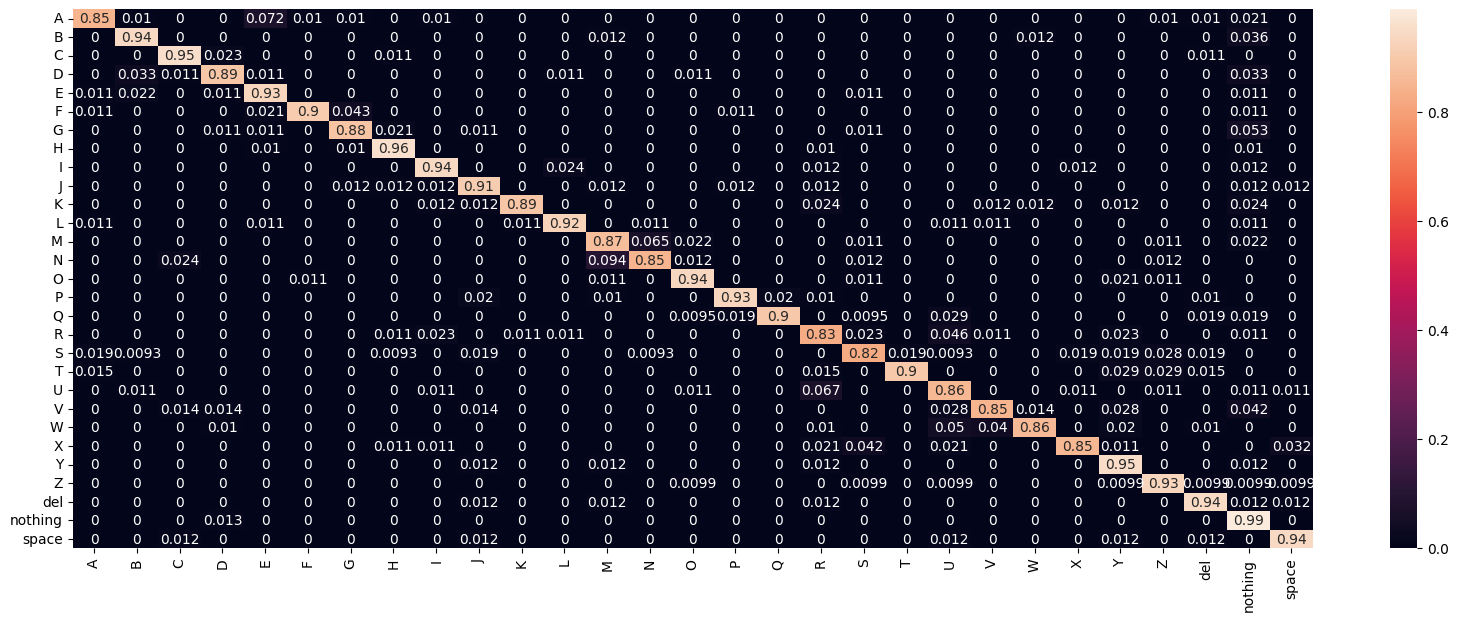

In [25]:
eval_model(model)